# Packages

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.set_default_tensor_type('torch.DoubleTensor')
from mpc import quadrotor_mpc

/opt/conda/envs/sindy_rl_2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# NN Model

In [2]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(12, 25)
        self.fc2 = nn.Linear(25, 30)
        self.fc3 = nn.Linear(30, 15)
        self.fc4 = nn.Linear(15, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

In [3]:
def read_weight(filename):
    model_weight = torch.load(filename)
    model = Network()
    model.load_state_dict(model_weight)
    return model

# Drone

**Dynamics**
$$m\ddot{z} = -mg + u + f_a(z,\dot{z}),\quad 0 \leq u \leq 1.7mg$$

In [4]:
class Drone:

    def __init__(self, init_z=1.5, init_v=0, C=1.0, h_d=0.0, delay=0.2, sim_duration=10, 
            theta=None, oracle=False, open_loop=False, model_fa=None, ft_names=None):
        # Drone parameters
        self.mass = 1.47                  # mass
        self.g = 9.81                     # gravity
        self.drone_height = 0.09          # drone's self-height
        self.delay = delay                # control delay, 0 if there is no delay
        self.thrust_max = 1.7             # control constrain, 0 <= u <= 1.7mg
        
        # NN model for unknown dynamics
        self.Fa_model = read_weight('Fa_net_12_3_full_Lip16.pth')
        self.model_fa = model_fa

        # Control parameters
        self.gain = 1.0
        self.oracle = oracle

        # Desired trajectory parameters
        self.C = C                        # how fast to land
        self.h_d = h_d                    # desired landing height 
        
        # Real states
        self.init_z = init_z
        self.z = init_z                   # height
        self.v = init_v                   # velocity
        self.a = 0                        # acceleration
        self.u_d = 0                      # desired control signal
        self.u = 0                        # control signal              
        self.prev_u = 6508                # previous control signal
        self.Fa = 0                       # observed Fa
        self.Fa_nn = 0                    # Fa directly from the NN model
        self.Fa_mod = 0

        # Noise
        self.a_noise_sigma = 0.1 
        self.u_noise_sigma = 0
        self.a_noise = 0
        self.u_noise = 0

        # Step
        self.step_size = 1e-2
        self.total_step = 0 
        self.sim_duration = sim_duration

        # Misc.
        self.open_loop = open_loop
        if self.open_loop:
            self.y = self.schroeder_sweep()
        self.theta = theta
        self.ft_names = ft_names
    
    def schroeder_sweep(self):
        def get_phi(p, N, phi1 = -np.pi/2):
            phi = [phi1]
            for i in range(len(p)):
                if i == 0:
                    continue
                gt = phi1 - 2*np.pi*(i+1)*sum(p[:i]) + 2*np.pi*sum([j*p[j] for j in range(i)])
                phi.append(gt)
            return phi

        def get_r(t, p, N, T, phi1=-np.pi/2, k=1):
            phi = get_phi(p, N)
            rs = [0 for _ in range(k)]
            for i in range(N):
                rs[i % k] += np.sqrt(p[i]/2) * np.cos(2*np.pi*i*t/T + phi[i]) + 0.5
            return rs[0] if k == 1 else rs

        N = 40
        p = [1/N for i in range(N)] # flat power spectra
        p = [(1/8)*np.sin(np.pi*(2*i - 1)/32)**2 for i in range(N)] # not-flat power spectra
        T = 10
        ts = np.array([i*self.step_size for i in range(int(np.ceil(self.sim_duration/self.step_size)))])
        k = 1
        y = [get_r(t, p, N, T) for t in ts]
        return y
        
    def noise(self):
        # Noise freq is 10
        if not self.total_step % int(1 / self.step_size * 0.1): 
            self.a_noise = np.random.normal(0, self.a_noise_sigma)
            if self.a_noise > 3 * self.a_noise_sigma:
                self.a_noise = 3 * self.a_noise_sigma
            if self.a_noise < -3 * self.a_noise_sigma:
                self.a_noise = -3 * self.a_noise_sigma

            self.u_noise = np.random.normal(0, self.u_noise_sigma)
            if self.u_noise > 3 * self.u_noise_sigma:
                self.u_noise = 3 * self.u_noise_sigma
            if self.u_noise < -3 * self.u_noise_sigma:
                self.u_noise = -3 * self.u_noise_sigma
                
    def baseline_controller(self):
        t = self.step_size * self.total_step
        z_d = np.exp(-self.C*t) * (1+self.C*t) * (self.init_z-self.h_d) + self.h_d
        z_dot_d = np.exp(-self.C*t) * (-self.C**2*t) * (self.init_z-self.h_d)
        z_ddot_d = np.exp(-self.C*t) * (self.C**3*t-self.C**2)

        # Here mean is the mean of Fa_hat
        mean = 0
        if self.oracle:
            mean = self.Fa_nn
        elif self.model_fa is not None:
            mean = self.model_fa(np.array([self.z, self.v]))

        self.u_d = self.mass * (self.g + z_ddot_d - 2*self.gain*(self.v-z_dot_d) - self.gain**2*(self.z-z_d)) - mean
        
        # Consider control delay
        u = (1-self.delay) * self.prev_u + self.delay * self.u_d 
        
        # Control constrain
        if u > self.thrust_max*self.mass*self.g:
            u = self.thrust_max*self.mass*self.g
        if u < 0:
            u = 0

        # Control noise
        u = u + self.u_noise

        self.u = u
        self.prev_u = u

    def open_loop_controller(self):
        u = self.y[self.total_step]
        self.u = u

    def MPC(self):
        print("Total step", self.total_step)
        _, u = quadrotor_mpc(self.ft_names, self.theta, 1, self.z, self.v, m=self.mass, g=self.g)
        self.u = u[0][0]

    def dynamics(self):
        # use prediction from NN as ground truth
        if self.model_fa is not None:
            self.Fa_mod = self.model_fa(np.array([self.z, self.v]))
        state = np.zeros([1,12])
        state[0,0] = self.z + self.drone_height
        state[0,3] = self.v
        state[0,7] = 1.0
        state[0,8:12] = 6508.0/8000
        state_torch = torch.from_numpy(state)
        Fa = self.Fa_model(state_torch)[0, 2].item()
        self.a = self.u/self.mass - self.g + self.a_noise + Fa/self.mass # changed this to be wrong
        self.Fa_nn = Fa

    # ODE solver: Euler
    def process(self):
        self.noise()
        if self.theta is not None:
            self.MPC()
        elif self.open_loop:
            self.open_loop_controller()
        else:
            self.baseline_controller()
        self.dynamics()
        
        self.z = self.z + self.step_size * self.v
        self.v = self.v + self.step_size * self.a
        
        self.Fa = self.mass * (self.a + self.g) - self.u
        self.total_step += 1

    def simulate(self):
        Height = []
        Height = np.append(Height, self.z)
        Velocity = []
        Velocity = np.append(Velocity, self.v)
        Control = []
        Acceleration = []
        Fa = []
        Fa_nn = []
        Fa_mod = []
        
        while True:
            self.process()
            Height = np.append(Height, self.z)
            Velocity = np.append(Velocity, self.v)
            Control = np.append(Control, self.u)
            Acceleration = np.append(Acceleration, self.a)
            Fa = np.append(Fa, self.Fa)
            Fa_nn = np.append(Fa_nn, self.Fa_nn)
            Fa_mod = np.append(Fa_mod, self.Fa_mod)

            if not self.total_step % int(1 / self.step_size):
                print('Simulation time: ' + str(self.total_step*self.step_size))

            if self.step_size*self.total_step >= self.sim_duration:
                break

        return Height[:-1], Velocity[:-1], Control, Acceleration, Fa, Fa_nn, Fa_mod

# Simulation

In [5]:
def sim(drone):
    Height, Velocity, Control, Acceleration, Fa, Fa_nn, Fa_model = drone.simulate()
    time = np.linspace(drone.step_size, drone.sim_duration, len(Height))

    plt.figure(figsize=(16,7))
    plt.subplot(2, 4, 1)
    plt.plot(time[:], Height)
    plt.xlabel("time [s]")
    plt.ylabel("height [m]")
    plt.title("height")
    plt.hlines(y=0, xmin=drone.step_size, xmax=drone.sim_duration, color='r', linestyles='--')

    plt.subplot(2, 4, 2)
    plt.plot(time[:], Velocity)
    plt.xlabel("time [s]")
    plt.ylabel("velocity [m/s]")
    plt.title("velocity")
    plt.hlines(y=0, xmin=drone.step_size, xmax=drone.sim_duration, color='r', linestyles='--')

    plt.subplot(2, 4, 3)
    plt.plot(time[:], Control)
    plt.xlabel("time [s]")
    plt.ylabel("control [rps]")
    plt.title("control")

    plt.subplot(2, 4, 4)
    plt.plot(Velocity, Height)
    plt.xlabel("velocity [m/s]")
    plt.ylabel("height [m]")
    plt.title("velocity v.s. height")

    plt.subplot(2, 4, 5)
    plt.plot(time[:], Fa)
    plt.xlabel("time [s]")
    plt.ylabel("Fa [N]")
    plt.title("Fa")
    
    plt.subplot(2, 4, 6)
    plt.plot(time[:], Fa_nn)
    plt.xlabel("time [s]")
    plt.ylabel("Fa_nn [N]")
    plt.title("Fa_nn")

    plt.subplot(2, 4, 7)
    plt.plot(time[:], Fa_model)
    plt.xlabel("time [s]")
    plt.ylabel("Fa_model [N]")
    plt.title("Fa_model")
    
    plt.tight_layout()
    plt.show()
    return Height, Velocity, Control, Acceleration, Fa, Fa_nn, Fa_model

In [6]:
from sklearn.preprocessing import PolynomialFeatures
import itertools
# X = np.array([z,v]).T
# y = np.array([fa_nn]).T
fa_gt = read_weight('Fa_net_12_3_full_Lip16.pth')
drone_height = 0.09
def get_fa_gt(z, v):
    state = np.zeros([1,12])
    state[0,0] = z + drone_height
    state[0,3] = v
    state[0,7] = 1.0
    state[0,8:12] = 6508.0/8000
    state_torch = torch.from_numpy(state)
    return fa_gt(state_torch)[0, 2].item()
Z = np.linspace(0, 3, 200)
V = np.linspace(-2, 2, 200)
X = np.array(list(itertools.product(Z,V)))
y = [get_fa_gt(x[0], x[1]) for x in X]
ps = PolynomialFeatures(degree=4)
X_features = ps.fit_transform(X)
coefs = np.linalg.lstsq(X_features, y)
params = coefs[0]
ft_names = list(ps.get_feature_names_out())

def regress_fa(x):
    return np.dot(ps.fit_transform(np.array([x]))[0], params)



/tmp/ipykernel_18291/2994734029.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coefs = np.linalg.lstsq(X_features, y)


Total step 0

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2702
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      700

Total number of variables............................:      760
                     variables with only lower bounds:      246
                variables with lower and upper bounds:       50
                     variables with only upper bounds:        0
Total n

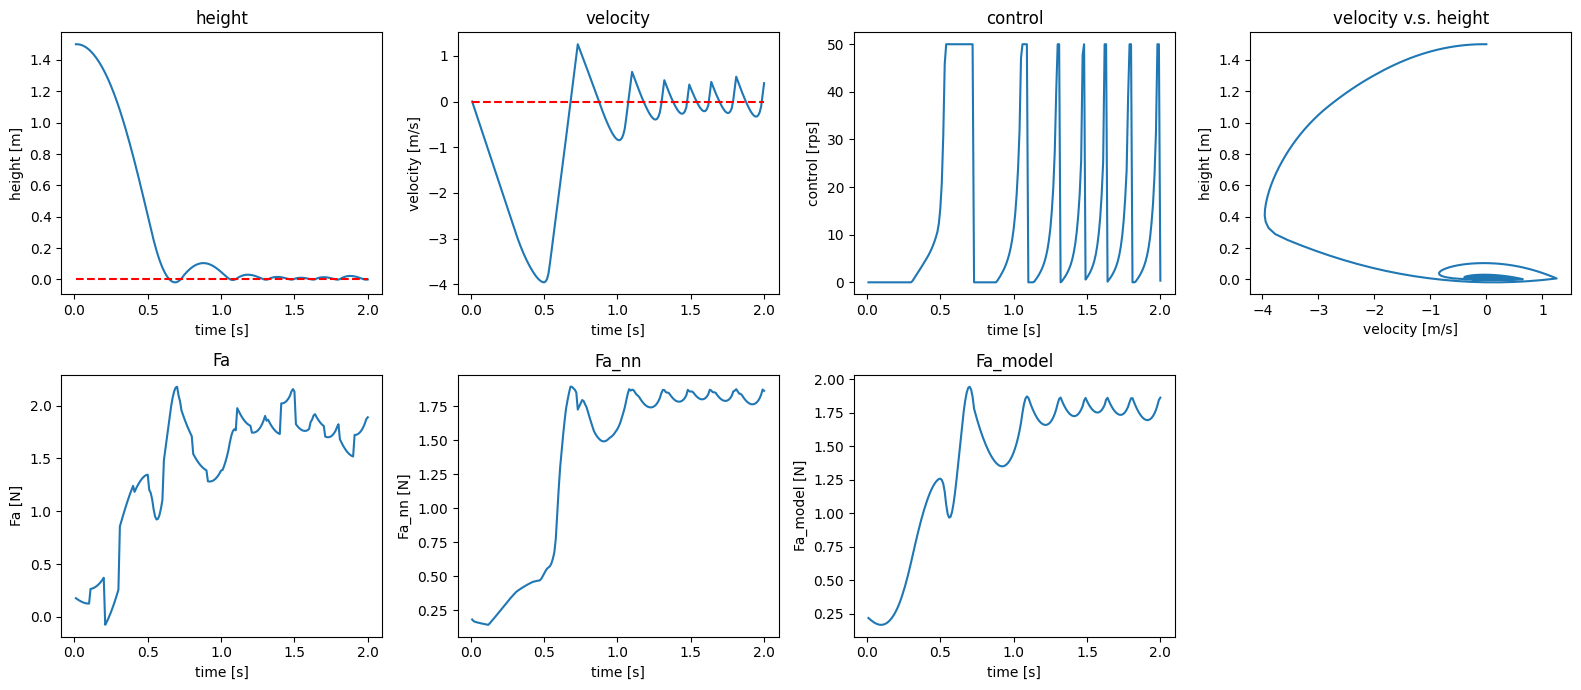

In [7]:
drone = Drone(oracle=False, open_loop=False, theta=params, ft_names=ft_names, sim_duration=2, model_fa=regress_fa)
z, v, u, a, fa, fa_nn, fa_model = sim(drone)

In [8]:
def CBC(Height, Velocity, Control):
    ## Returns theta_t
    pass

In [9]:
def meta_controller(init_theta, simulator, t_controller, t_meta, init_z=1.5, init_v=0):
    z_curr = init_z
    v_curr = init_v
    theta_curr = init_theta
    Height, Velocity, Control, Acceleration, Fa, Fa_nn = [], [], [], [], [], []
    for i in range(t_meta):
        drone = Drone(init_z=z_curr, init_v=v_curr, sim_duration=t_controller, theta=theta_curr)
        z, v, u, a, fa, fa_nn = sim(drone)
        Height += z
        Velocity += v
        Control += u
        Acceleration += a
        Fa += fa
        Fa_nn += fa_nn
        z_curr = Height[-1]
        v_curr = Velocity[-1]
        theta_curr = CBC(Height, Velocity, Control)
    return Height, Velocity, Control, Acceleration, Fa, Fa_nn